# **Multi-Mapping Reads: Training & Evaluation**
### ***E. coli (Seed=512)***
* **Multi-Layer Perceptron**
* **11 Configurations: k = 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 and Without k-mers**

# Configurations

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
import os
import shutil

plt.rcParams['font.family'] = 'serif'            # Use a specific font
plt.rcParams['font.size'] = 13                   # Set a general font size

2025-10-03 15:24:04.981437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759505045.210232      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759505045.279524      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ROOT_DIR = '/kaggle/input/mmr-dataprep-ecoli/ecoli/data'
DATA_DIR = os.path.join(ROOT_DIR, 'seed512')  # Seed = 512

ROOT_OUTPUT_DIR = '/kaggle/working/'

DISPLAY_LABELS = ['Incorrect', 'Correct']
EPOCHS = 400
BATCH_SIZE = 128
LEARNING_RATE = 5e-4

In [3]:
X_train = pd.read_csv(os.path.join(DATA_DIR, 'x_train.csv'))
X_val = pd.read_csv(os.path.join(DATA_DIR, 'x_val.csv'))
X_test = pd.read_csv(os.path.join(DATA_DIR, 'x_test.csv'))
y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train.csv')).iloc[:, 0]
y_val = pd.read_csv(os.path.join(DATA_DIR, 'y_val.csv')).iloc[:, 0]
y_test = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv')).iloc[:, 0]

In [4]:
# Utility function: keep k=? columns

def slice_x(x, k_to_keep=9, rna_seq=True):
    # Keep or discard RNA-seq columns
    if not rna_seq:
        cols_to_keep = [f for f in x.columns.values if f not in ['bowtie', 'p_val', 'z_score'] and not f.startswith('tfidf_k')]
    else:
        cols_to_keep = [f for f in x.columns.values if f not in ['bowtie',] and not f.startswith('tfidf_k')]
    
    # Select tfidf columns
    if k_to_keep:
        cols_to_keep.extend([f for f in x.columns.values if f.startswith(f'tfidf_k{k_to_keep}_')])
    
    x_sliced = x[cols_to_keep].copy()
    return x_sliced

# Example
slice_x(X_train, k_to_keep=7).columns.values[:50]

array(['r1_start', 'r1_end', 'r1_mapq', 'r1_is_reverse', 'r2_start',
       'r2_end', 'r2_mapq', 'r2_is_reverse', 'weight', 'p_val', 'z_score',
       'chr_NC_000913.3', 'r1_flag_83', 'r1_flag_99', 'r1_flag_339',
       'r1_flag_355', 'r2_flag_147', 'r2_flag_163', 'r2_flag_403',
       'r2_flag_419', 'tfidf_k7_0', 'tfidf_k7_1', 'tfidf_k7_2',
       'tfidf_k7_3', 'tfidf_k7_4', 'tfidf_k7_5', 'tfidf_k7_6',
       'tfidf_k7_7', 'tfidf_k7_8', 'tfidf_k7_9', 'tfidf_k7_10',
       'tfidf_k7_11', 'tfidf_k7_12', 'tfidf_k7_13', 'tfidf_k7_14',
       'tfidf_k7_15', 'tfidf_k7_16', 'tfidf_k7_17', 'tfidf_k7_18',
       'tfidf_k7_19', 'tfidf_k7_20', 'tfidf_k7_21', 'tfidf_k7_22',
       'tfidf_k7_23', 'tfidf_k7_24', 'tfidf_k7_25', 'tfidf_k7_26',
       'tfidf_k7_27', 'tfidf_k7_28', 'tfidf_k7_29'], dtype=object)

In [5]:
# k=6 for k-mers
X_train_k6 = slice_x(X_train, k_to_keep=6)
X_val_k6   = slice_x(X_val,   k_to_keep=6)
X_test_k6  = slice_x(X_test,  k_to_keep=6)

# k=7 for k-mers
X_train_k7 = slice_x(X_train, k_to_keep=7)
X_val_k7   = slice_x(X_val,   k_to_keep=7)
X_test_k7  = slice_x(X_test,  k_to_keep=7)

# k=8 for k-mers
X_train_k8 = slice_x(X_train, k_to_keep=8)
X_val_k8   = slice_x(X_val,   k_to_keep=8)
X_test_k8  = slice_x(X_test,  k_to_keep=8)

# k=9 for k-mers
X_train_k9 = slice_x(X_train, k_to_keep=9)
X_val_k9   = slice_x(X_val,   k_to_keep=9)
X_test_k9  = slice_x(X_test,  k_to_keep=9)

# k=10 for k-mers
X_train_k10 = slice_x(X_train, k_to_keep=10)
X_val_k10   = slice_x(X_val,   k_to_keep=10)
X_test_k10  = slice_x(X_test,  k_to_keep=10)

# k=11 for k-mers
X_train_k11 = slice_x(X_train, k_to_keep=11)
X_val_k11   = slice_x(X_val,   k_to_keep=11)
X_test_k11  = slice_x(X_test,  k_to_keep=11)

# k=12 for k-mers
X_train_k12 = slice_x(X_train, k_to_keep=12)
X_val_k12   = slice_x(X_val,   k_to_keep=12)
X_test_k12  = slice_x(X_test,  k_to_keep=12)

# k=13 for k-mers
X_train_k13 = slice_x(X_train, k_to_keep=13)
X_val_k13   = slice_x(X_val,   k_to_keep=13)
X_test_k13  = slice_x(X_test,  k_to_keep=13)

# k=14 for k-mers
X_train_k14 = slice_x(X_train, k_to_keep=14)
X_val_k14   = slice_x(X_val,   k_to_keep=14)
X_test_k14  = slice_x(X_test,  k_to_keep=14)

# k=15 for k-mers
X_train_k15 = slice_x(X_train, k_to_keep=15)
X_val_k15   = slice_x(X_val,   k_to_keep=15)
X_test_k15  = slice_x(X_test,  k_to_keep=15)

# Without k-mers
X_train_wo = slice_x(X_train, k_to_keep=None)
X_val_wo   = slice_x(X_val,   k_to_keep=None)
X_test_wo  = slice_x(X_test,  k_to_keep=None)

# Multi-Layer Perceptron

In [6]:
# ------------------------------
# Define NN model builder
# ------------------------------

def build_model(input_dim, k=9):
    model = Sequential([
        Input(shape=(input_dim,)),   # Explicit Input layer
        Dense(256),
        BatchNormalization(), 
        Activation("relu"),
        Dropout(0.4),
        Dense(128),
        BatchNormalization(), 
        Activation("relu"),
        Dropout(0.3),
        Dense(64),
        BatchNormalization(), 
        Activation("relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")   # binary classification
    ], name=f'MLP_k{k}')
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False, gamma=2.0, alpha=0.2),
                  #loss='binary_crossentropy',
                  metrics=["accuracy",
                           Precision(name='precision'),
                           Recall(name='recall')])
    return model


In [7]:
def evaluate_scores_and_plot(m, X, y, df, k=9):
    ## Evaluate on test dataset
    print(f'# Classification Report: (K={k})')
    score = m.evaluate(X, y, verbose=0)
    print(f'Test loss      : {score[0]}')
    print(f'Test accuracy  : {score[1]}')
    print(f'Test precision : {score[2]}')
    print(f'Test recall    : {score[3]}')
    
    # Classification report + confusion matrix
    y_pred_probs = m.predict(X, verbose=0)   # Probabilities
    y_pred = (y_pred_probs > 0.5).astype(int)   # Convert to 0/1 labels
    cf_matrix = confusion_matrix(y, y_pred)
    print('')
    print(classification_report(y, y_pred, digits=4, target_names=DISPLAY_LABELS))
    print('')

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(df.loss, label='Training')
    plt.plot(df.val_loss, label='Validation')
    plt.title(f'Loss (K={k})')
    plt.grid()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(df.accuracy, label='Training')
    plt.plot(df.val_accuracy, label='Validation')
    plt.title(f'Accuracy (K={k})')
    plt.grid()
    plt.legend()
    plt.show()
    
    # Plotm confusion matrix
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=DISPLAY_LABELS)
    cmd.plot(cmap='Blues')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(m, X, y, k=9):
    """
    Plots the ROC curve and returns the AUC score.
    """
    if hasattr(m, "predict_proba"):
        y_pred_probs = m.predict_proba(X)[:, 1]
    elif hasattr(m, "decision_function"):
        y_pred_probs = m.decision_function(X)
    else:  # Keras or TF model
        y_pred_probs = m.predict(X, verbose=0).ravel()

    fpr, tpr, thresholds = roc_curve(y, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="blue", lw=2,
             label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC (K={k})')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    return roc_auc

def plot_pr_curve(m, X, y, k=9):
    positive_label = 0  # we care about 'Incorrect' = 0

    # ---- Get scores oriented so higher = more likely 'Incorrect' (label 0)
    if hasattr(m, "predict_proba"):
        if hasattr(m, "classes_") and len(getattr(m, "classes_", [])) == 2:
            col = int(np.where(m.classes_ == positive_label)[0][0])
        else:
            col = 0  # fallback
        y_scores = m.predict_proba(X)[:, col]

    elif hasattr(m, "decision_function"):
        s = m.decision_function(X)
        # In sklearn binary, decision_function > 0 corresponds to classes_[1]
        if hasattr(m, "classes_") and len(m.classes_) == 2:
            y_scores = s if positive_label == m.classes_[1] else -s
        else:
            y_scores = -s  # assume pos=1 by default; negate to make pos=0

    else:  # Keras/TF sigmoid: predict returns P(class=1 = 'Correct')
        p1 = np.asarray(m.predict(X, verbose=0)).ravel()
        y_scores = 1.0 - p1  # P(class=0 = 'Incorrect')

    # ---- PR for class 0
    precision, recall, _ = precision_recall_curve(y, y_scores, pos_label=positive_label)
    ap = average_precision_score(y, y_scores, pos_label=positive_label)
    baseline = float(np.mean(y == positive_label))  # prevalence of 'Incorrect'

    # ---- Plot (same look & feel as your ROC)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color="blue", lw=2,
             label=f"PR curve (AP = {ap:.4f})")
    plt.hlines(baseline, xmin=0, xmax=1, colors="gray", linestyles="--", lw=1,
               label=f"Baseline = {baseline:.4f}")
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'Precision–Recall (K={k})')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

    return ap


In [8]:
# Training config
from sklearn.utils import class_weight

# Print class weight here
cls_w = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
cls_w_dict = dict(zip(np.unique(y_train), cls_w))
print('Class weights:', cls_w_dict)

def train_model(X, y, Xv, yv, k=9, seed=512):
    # Build model
    model = build_model(input_dim=X.shape[1])
    
    cb = [
        EarlyStopping(monitor="val_loss", patience=30),
        ModelCheckpoint(filepath=os.path.join(ROOT_OUTPUT_DIR, 'model_temp.keras'), monitor='val_loss', save_best_only=True)
    ]
    # Train model
    history = model.fit(
        X, y,
        callbacks=cb,
        validation_data=(Xv, yv),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0, #class_weight=cls_w_dict
    )
    TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
    MODEL_SAVE_PATH = os.path.join(ROOT_OUTPUT_DIR, f'model_ecoli_s{seed}_k{k}_' + TIMESTAMP + '.keras')
    HISTORY_SAVE_PATH = os.path.join(ROOT_OUTPUT_DIR, f'history_ecoli_s{seed}_k{k}_' + TIMESTAMP + '.csv')
    
    # Save the best model
    shutil.move(os.path.join(ROOT_OUTPUT_DIR, 'model_temp.keras'), MODEL_SAVE_PATH)
    print('Model saved in:', MODEL_SAVE_PATH)
    df = pd.DataFrame(history.history)
    df.to_csv(HISTORY_SAVE_PATH)
    print('History saved in:', HISTORY_SAVE_PATH)
    return df, MODEL_SAVE_PATH


Class weights: {0: 1.4276600985221675, 1: 0.7694952606005895}


# Feature: 6-mers

In [9]:
build_model(X_train_k6.shape[1], k=6).summary()

2025-10-03 15:25:19.554745: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "MLP_k6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        50,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,185 (364.00 KB)

 Trainable params: 92,289 (360.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
df_k6, best_path_k6 = train_model(X_train_k6, y_train, X_val_k6, y_val, k=6)

Model saved in: /kaggle/working/model_ecoli_s512_k6_20251003_153749.keras
History saved in: /kaggle/working/history_ecoli_s512_k6_20251003_153749.csv


# Classification Report: (K=6)
Test loss      : 0.10997778177261353
Test accuracy  : 0.7967513799667358
Test precision : 0.8161066770553589
Test recall    : 0.8870922923088074

              precision    recall  f1-score   support

   Incorrect     0.7502    0.6291    0.6844      5800
     Correct     0.8161    0.8871    0.8501     10761

    accuracy                         0.7968     16561
   macro avg     0.7832    0.7581    0.7672     16561
weighted avg     0.7930    0.7968    0.7921     16561




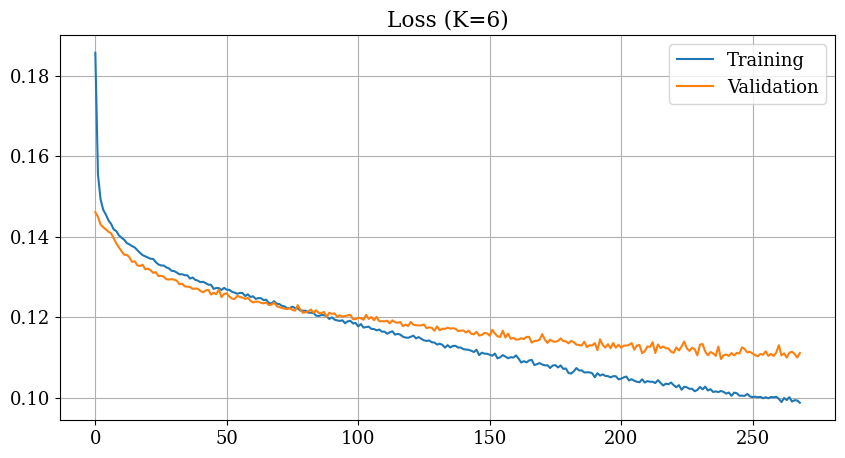

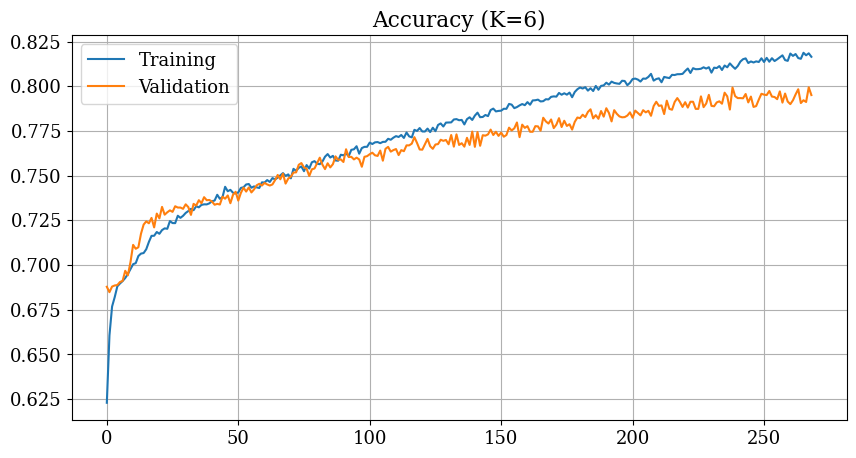

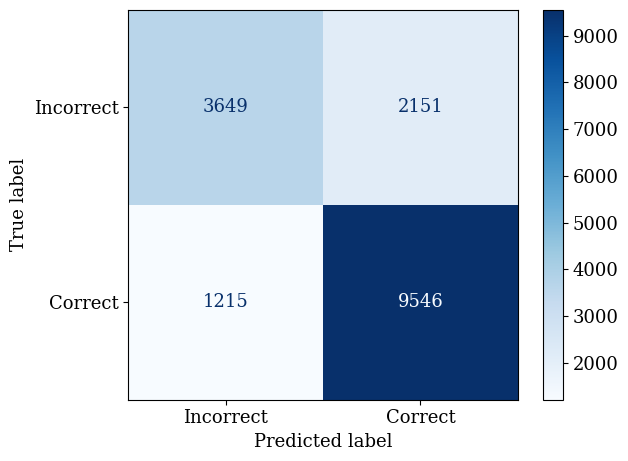

In [11]:
best_model_k6 = load_model(best_path_k6)
evaluate_scores_and_plot(m=best_model_k6, X=X_test_k6, y=y_test, df=df_k6, k=6)

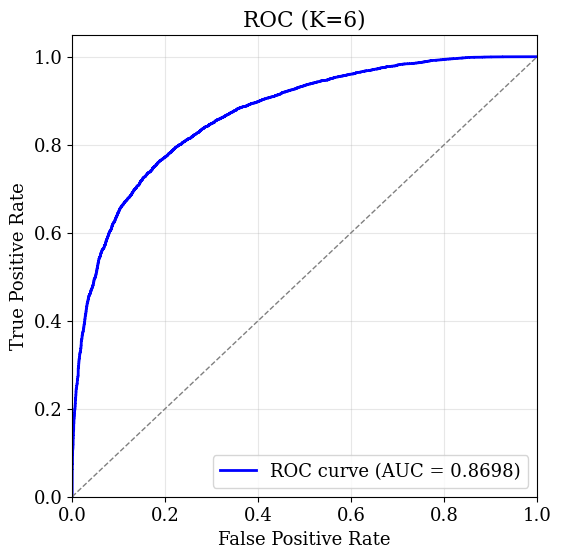

ROC=0.8697531235079422



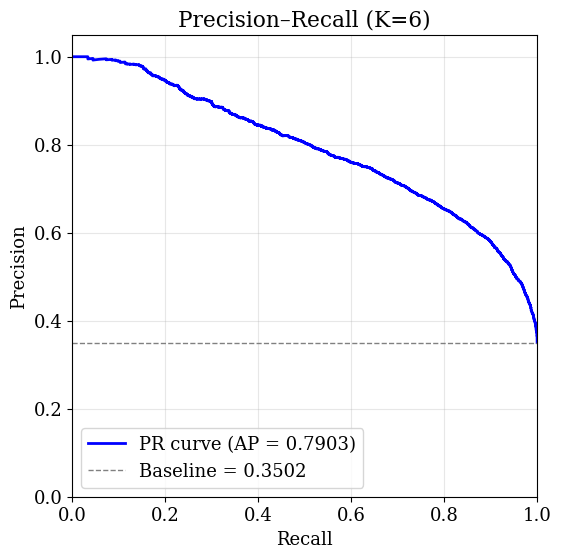

Average precision=0.7903363076837594


In [12]:
roc_k6 = plot_roc_curve(m=best_model_k6, X=X_test_k6, y=y_test, k=6)
print(f'ROC={roc_k6}')
print('')
ap_k6 = plot_pr_curve(m=best_model_k6, X=X_test_k6, y=y_test, k=6)
print(f'Average precision={ap_k6}')

# Feature: 7-mers

In [13]:
build_model(X_train_k7.shape[1], k=7).summary()

Model: "MLP_k7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,929 (363.00 KB)

 Trainable params: 92,033 (359.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
df_k7, best_path_k7 = train_model(X_train_k7, y_train, X_val_k7, y_val, k=7)

Model saved in: /kaggle/working/model_ecoli_s512_k7_20251003_155643.keras
History saved in: /kaggle/working/history_ecoli_s512_k7_20251003_155643.csv


# Classification Report: (K=7)
Test loss      : 0.10534853488206863
Test accuracy  : 0.81220942735672
Test precision : 0.8377925157546997
Test recall    : 0.8817024230957031

              precision    recall  f1-score   support

   Incorrect     0.7569    0.6833    0.7182      5800
     Correct     0.8378    0.8817    0.8592     10761

    accuracy                         0.8122     16561
   macro avg     0.7973    0.7825    0.7887     16561
weighted avg     0.8095    0.8122    0.8098     16561




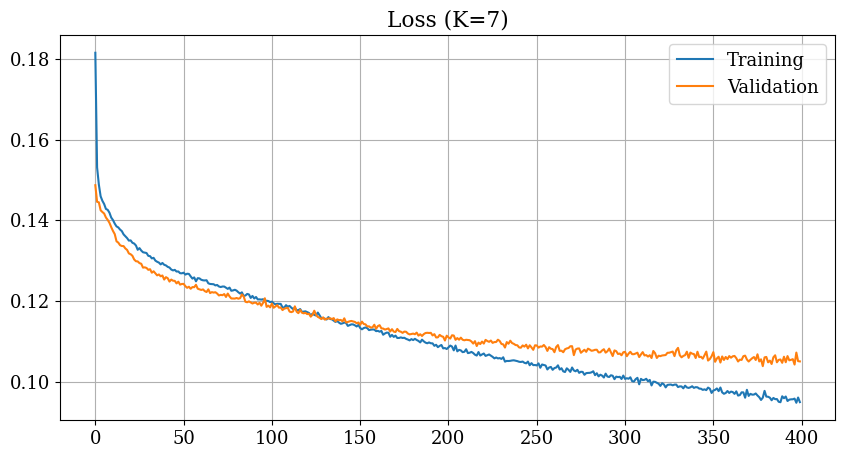

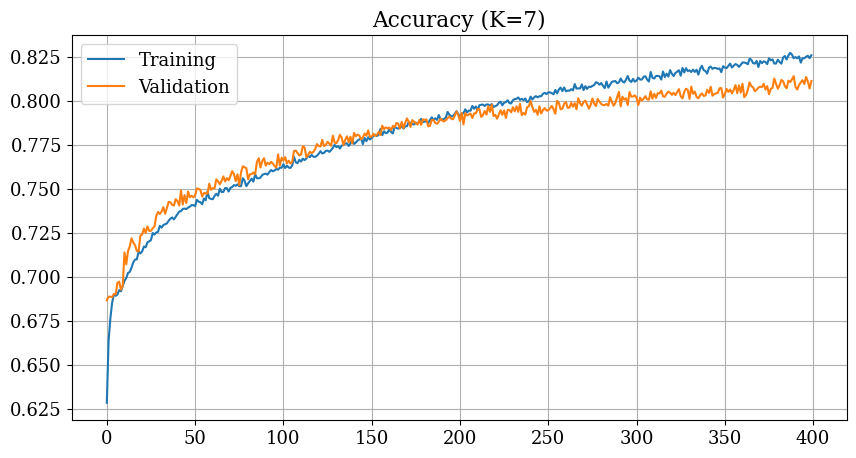

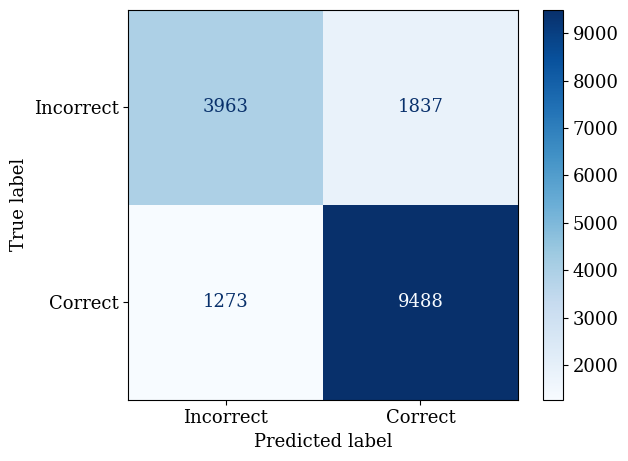

In [15]:
best_model_k7 = load_model(best_path_k7)
evaluate_scores_and_plot(m=best_model_k7, X=X_test_k7, y=y_test, df=df_k7, k=7)

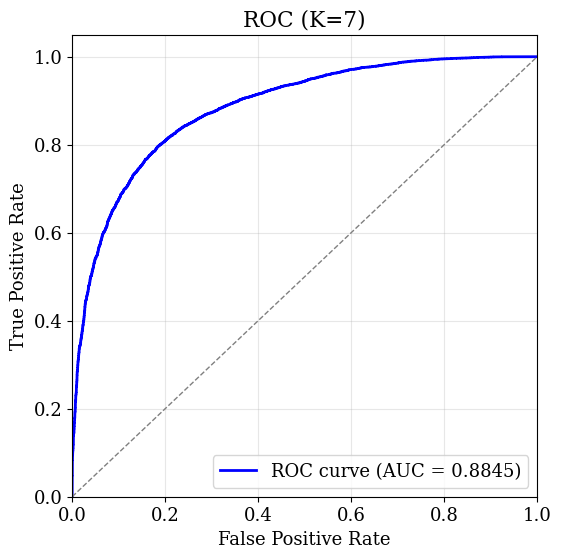

ROC=0.8844568268555992



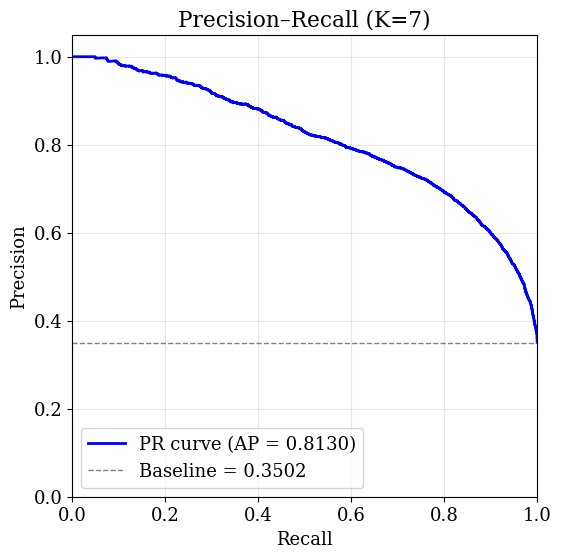

Average precision=0.8130073212943848


In [16]:
roc_k7 = plot_roc_curve(m=best_model_k7, X=X_test_k7, y=y_test, k=7)
print(f'ROC={roc_k7}')
print('')
ap_k7 = plot_pr_curve(m=best_model_k7, X=X_test_k7, y=y_test, k=7)
print(f'Average precision={ap_k7}')

# Feature: 8-mers

In [17]:
build_model(X_train_k8.shape[1], k=8).summary()

Model: "MLP_k8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,673 (362.00 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [18]:
df_k8, best_path_k8 = train_model(X_train_k8, y_train, X_val_k8, y_val, k=8)

Model saved in: /kaggle/working/model_ecoli_s512_k8_20251003_161559.keras
History saved in: /kaggle/working/history_ecoli_s512_k8_20251003_161559.csv


# Classification Report: (K=8)
Test loss      : 0.1005215272307396
Test accuracy  : 0.8231387138366699
Test precision : 0.8504564166069031
Test recall    : 0.8830963373184204

              precision    recall  f1-score   support

   Incorrect     0.7665    0.7119    0.7382      5800
     Correct     0.8505    0.8831    0.8665     10761

    accuracy                         0.8231     16561
   macro avg     0.8085    0.7975    0.8023     16561
weighted avg     0.8210    0.8231    0.8215     16561




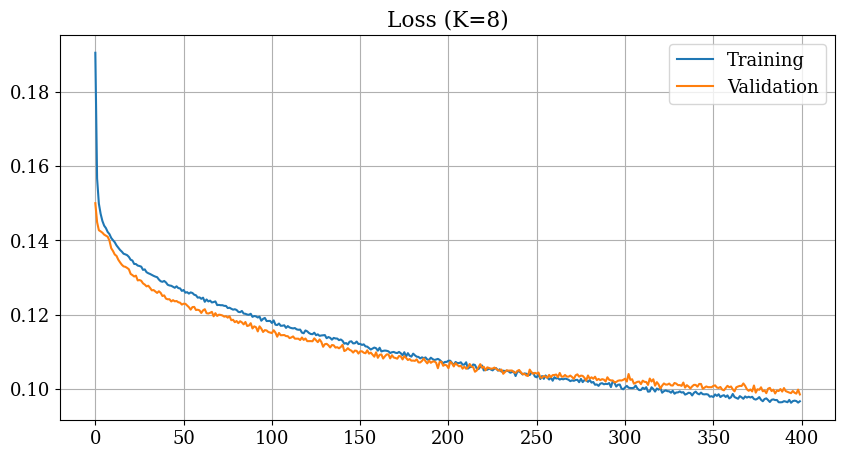

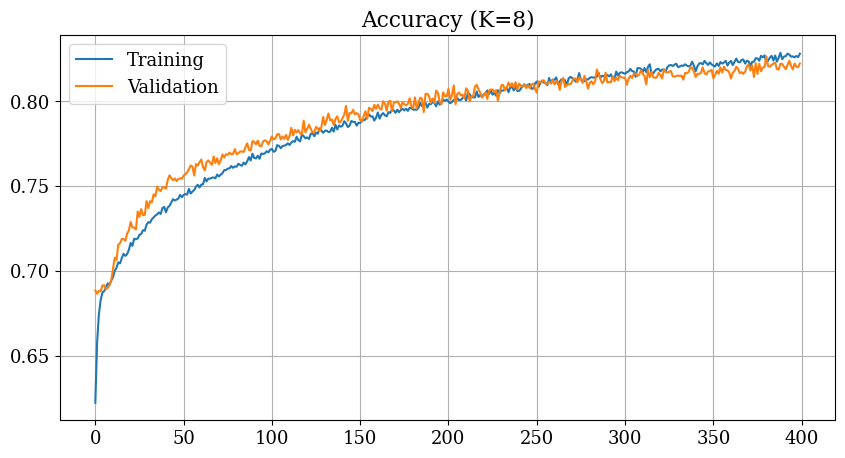

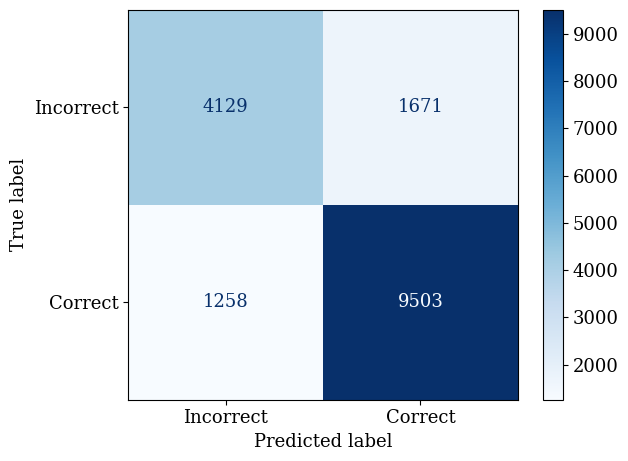

In [19]:
best_model_k8 = load_model(best_path_k8)
evaluate_scores_and_plot(m=best_model_k8, X=X_test_k8, y=y_test, df=df_k8, k=8)

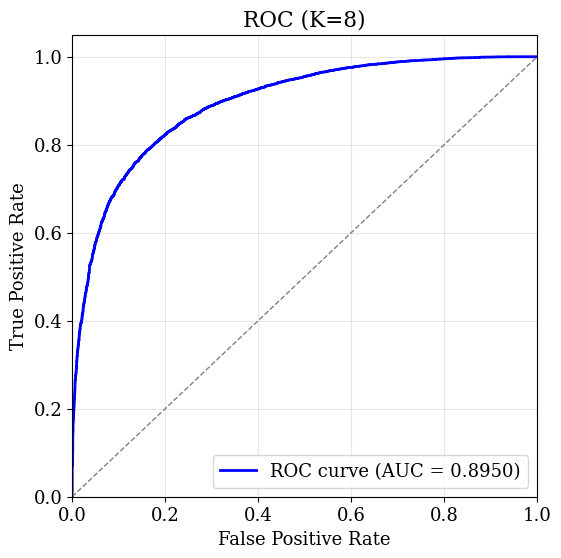

ROC=0.8950142756890302



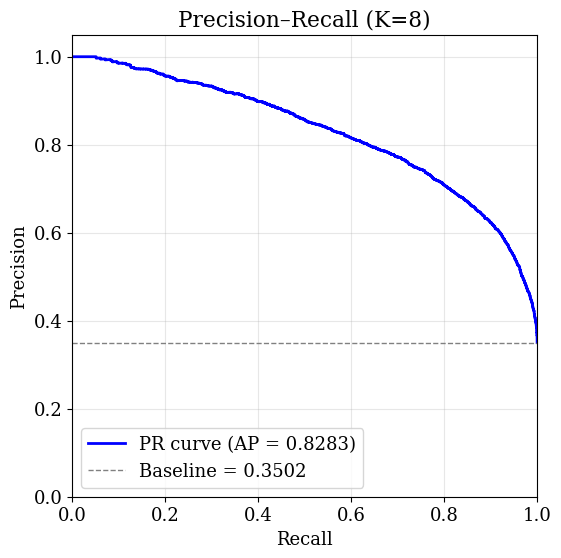

Average precision=0.8283325657875471


In [20]:
roc_k8 = plot_roc_curve(m=best_model_k8, X=X_test_k8, y=y_test, k=8)
print(f'ROC={roc_k8}')
print('')
ap_k8 = plot_pr_curve(m=best_model_k8, X=X_test_k8, y=y_test, k=8)
print(f'Average precision={ap_k8}')

# Feature: 9-mers

In [21]:
build_model(X_train_k9.shape[1], k=9).summary()

Model: "MLP_k9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,417 (361.00 KB)

 Trainable params: 91,521 (357.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
df_k9, best_path_k9 = train_model(X_train_k9, y_train, X_val_k9, y_val, k=9)

Model saved in: /kaggle/working/model_ecoli_s512_k9_20251003_163426.keras
History saved in: /kaggle/working/history_ecoli_s512_k9_20251003_163426.csv


# Classification Report: (K=9)
Test loss      : 0.09901120513677597
Test accuracy  : 0.8224141001701355
Test precision : 0.8648749589920044
Test recall    : 0.8612582683563232

              precision    recall  f1-score   support

   Incorrect     0.7446    0.7503    0.7474      5800
     Correct     0.8649    0.8613    0.8631     10761

    accuracy                         0.8224     16561
   macro avg     0.8047    0.8058    0.8053     16561
weighted avg     0.8227    0.8224    0.8226     16561




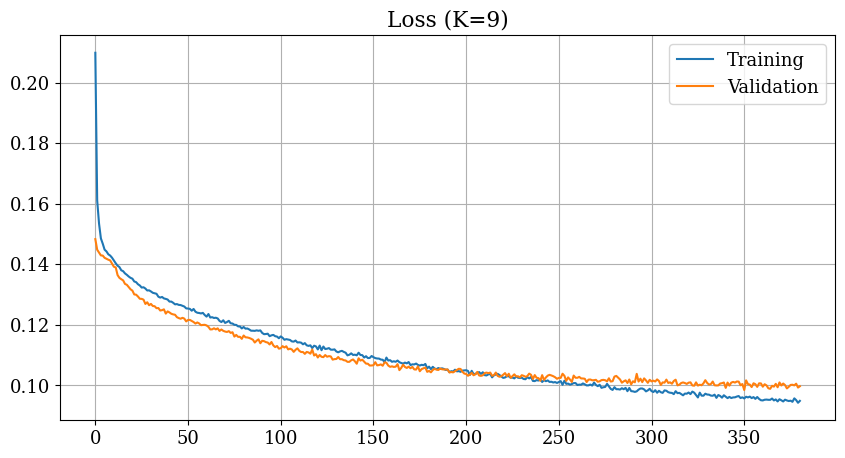

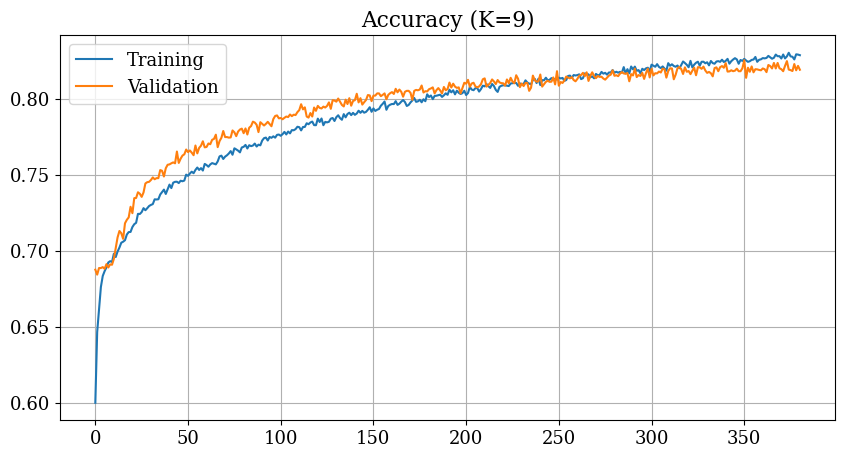

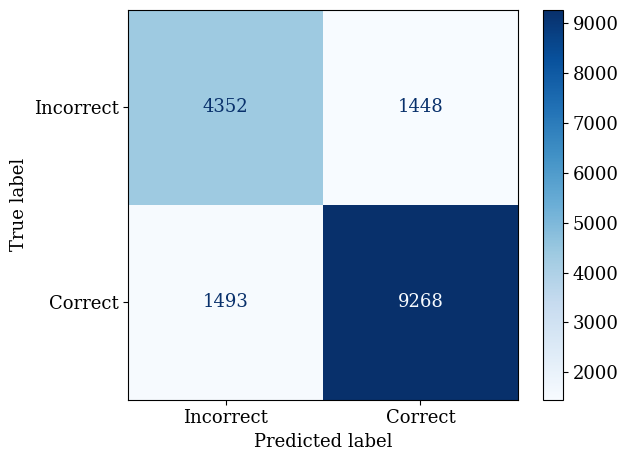

In [23]:
best_model_k9 = load_model(best_path_k9)
evaluate_scores_and_plot(m=best_model_k9, X=X_test_k9, y=y_test, df=df_k9, k=9)

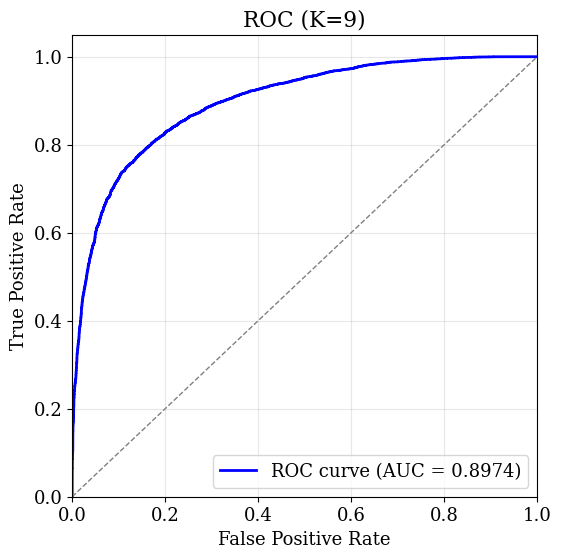

ROC=0.8974323466925584



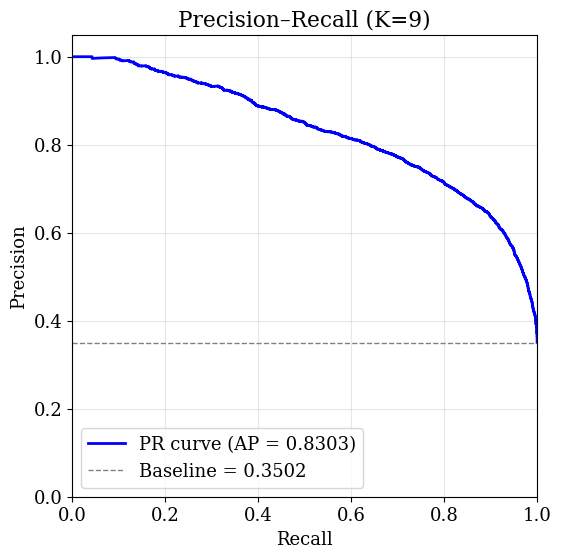

Average precision=0.8303260285217684


In [24]:
roc_k9 = plot_roc_curve(m=best_model_k9, X=X_test_k9, y=y_test, k=9)
print(f'ROC={roc_k9}')
print('')
ap_k9 = plot_pr_curve(m=best_model_k9, X=X_test_k9, y=y_test, k=9)
print(f'Average precision={ap_k9}')

# Feature: 10-mers

In [25]:
build_model(X_train_k10.shape[1], k=10).summary()

Model: "MLP_k10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 256)            │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,265 (356.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [26]:
df_k10, best_path_k10 = train_model(X_train_k10, y_train, X_val_k10, y_val, k=10)

Model saved in: /kaggle/working/model_ecoli_s512_k10_20251003_164528.keras
History saved in: /kaggle/working/history_ecoli_s512_k10_20251003_164528.csv


# Classification Report: (K=10)
Test loss      : 0.10415786504745483
Test accuracy  : 0.8128132224082947
Test precision : 0.8468713164329529
Test recall    : 0.869064211845398

              precision    recall  f1-score   support

   Incorrect     0.7447    0.7084    0.7261      5800
     Correct     0.8469    0.8691    0.8578     10761

    accuracy                         0.8128     16561
   macro avg     0.7958    0.7888    0.7920     16561
weighted avg     0.8111    0.8128    0.8117     16561




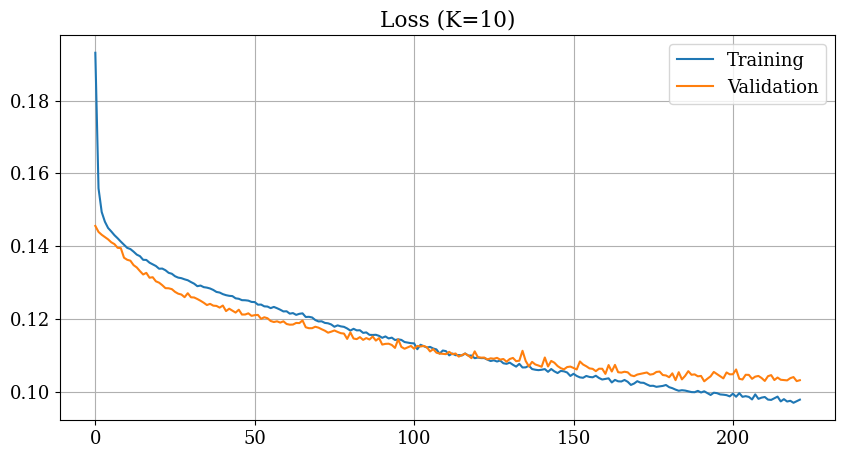

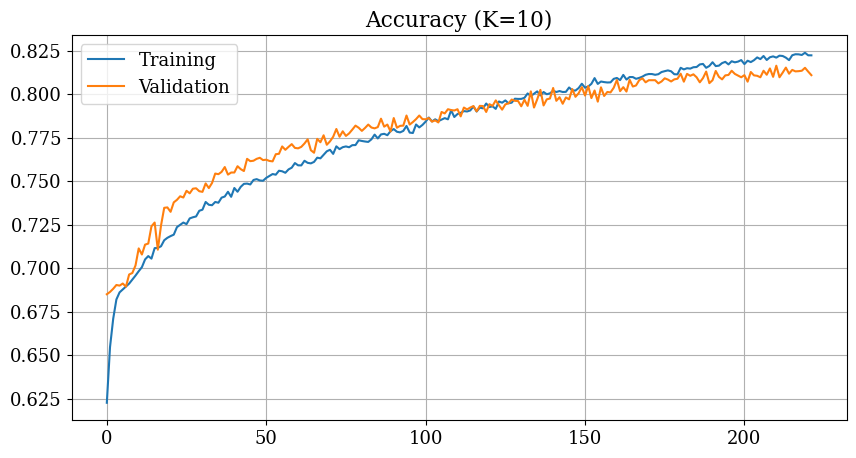

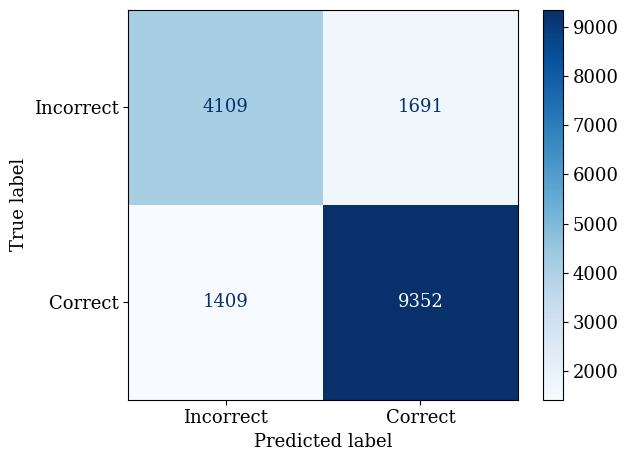

In [27]:
best_model_k10 = load_model(best_path_k10)
evaluate_scores_and_plot(m=best_model_k10, X=X_test_k10, y=y_test, df=df_k10, k=10)

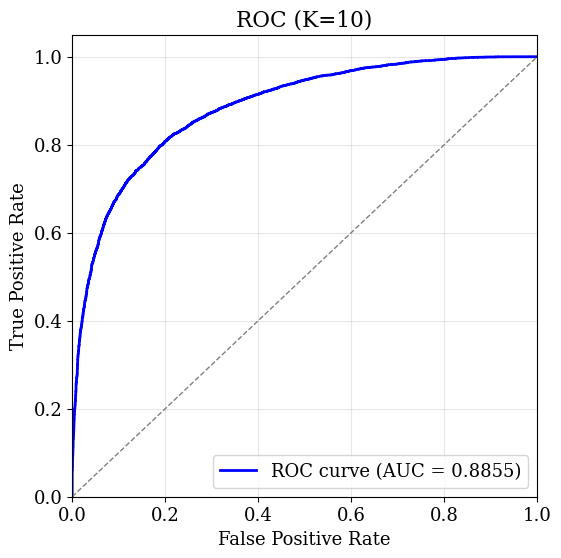

ROC=0.8854700402795536



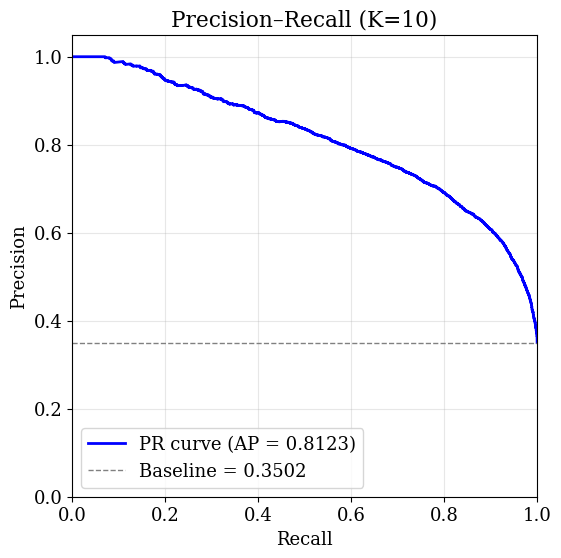

Average precision=0.8122634267242306


In [28]:
roc_k10 = plot_roc_curve(m=best_model_k10, X=X_test_k10, y=y_test, k=10)
print(f'ROC={roc_k10}')
print('')
ap_k10 = plot_pr_curve(m=best_model_k10, X=X_test_k10, y=y_test, k=10)
print(f'Average precision={ap_k10}')

# Feature: 11-mers

In [29]:
build_model(X_train_k11.shape[1], k=11).summary()

Model: "MLP_k11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 256)            │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,905 (359.00 KB)

 Trainable params: 91,009 (355.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [30]:
df_k11, best_path_k11 = train_model(X_train_k11, y_train, X_val_k11, y_val, k=11)

Model saved in: /kaggle/working/model_ecoli_s512_k11_20251003_165749.keras
History saved in: /kaggle/working/history_ecoli_s512_k11_20251003_165749.csv


# Classification Report: (K=11)
Test loss      : 0.1039169505238533
Test accuracy  : 0.8155908584594727
Test precision : 0.8448939323425293
Test recall    : 0.8772419095039368

              precision    recall  f1-score   support

   Incorrect     0.7548    0.7012    0.7270      5800
     Correct     0.8449    0.8772    0.8608     10761

    accuracy                         0.8156     16561
   macro avg     0.7999    0.7892    0.7939     16561
weighted avg     0.8134    0.8156    0.8139     16561




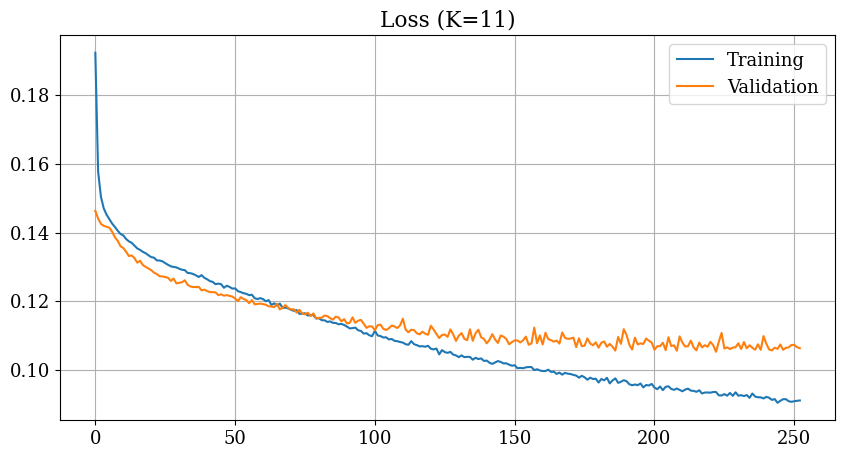

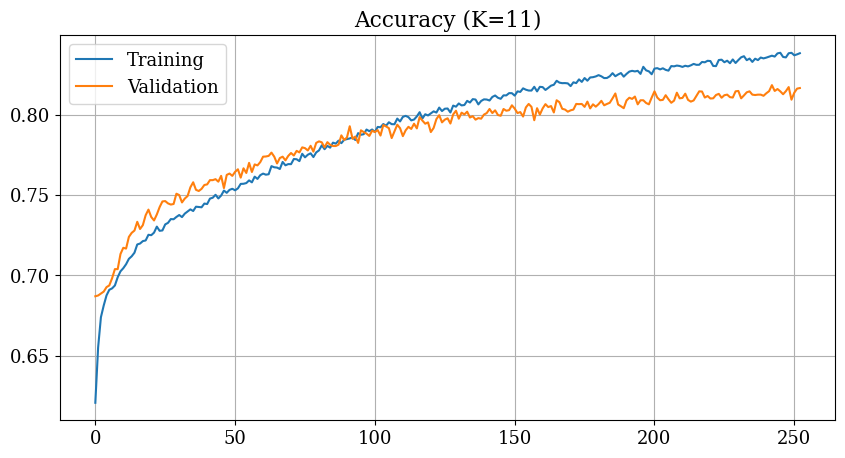

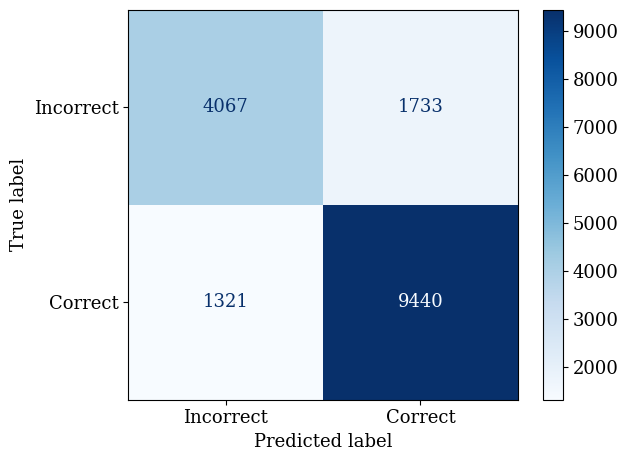

In [31]:
best_model_k11 = load_model(best_path_k11)
evaluate_scores_and_plot(m=best_model_k11, X=X_test_k11, y=y_test, df=df_k11, k=11)

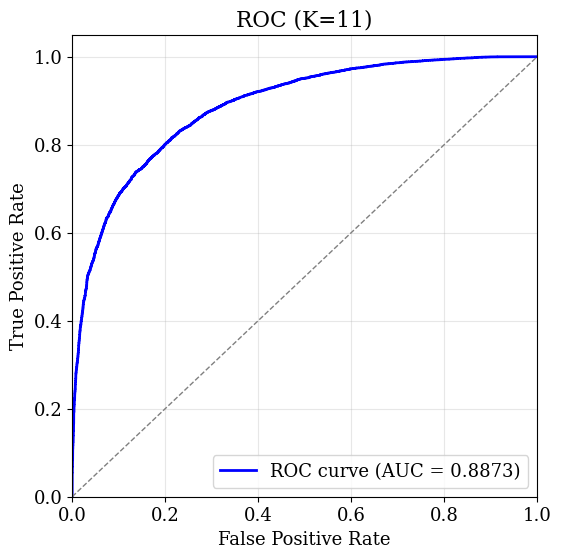

ROC=0.8872963671495727



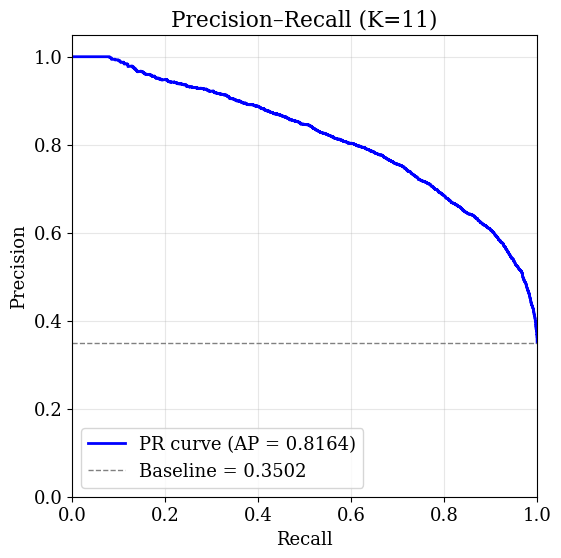

Average precision=0.8163871415817239


In [32]:
roc_k11 = plot_roc_curve(m=best_model_k11, X=X_test_k11, y=y_test, k=11)
print(f'ROC={roc_k11}')
print('')
ap_k11 = plot_pr_curve(m=best_model_k11, X=X_test_k11, y=y_test, k=11)
print(f'Average precision={ap_k11}')

# Feature: 12-mers

In [33]:
build_model(X_train_k12.shape[1], k=12).summary()

Model: "MLP_k12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,649 (358.00 KB)

 Trainable params: 90,753 (354.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
df_k12, best_path_k12 = train_model(X_train_k12, y_train, X_val_k12, y_val, k=12)

Model saved in: /kaggle/working/model_ecoli_s512_k12_20251003_171110.keras
History saved in: /kaggle/working/history_ecoli_s512_k12_20251003_171110.csv


# Classification Report: (K=12)
Test loss      : 0.10507752001285553
Test accuracy  : 0.8128132224082947
Test precision : 0.8440054059028625
Test recall    : 0.8733389377593994

              precision    recall  f1-score   support

   Incorrect     0.7488    0.7005    0.7239      5800
     Correct     0.8440    0.8733    0.8584     10761

    accuracy                         0.8128     16561
   macro avg     0.7964    0.7869    0.7911     16561
weighted avg     0.8107    0.8128    0.8113     16561




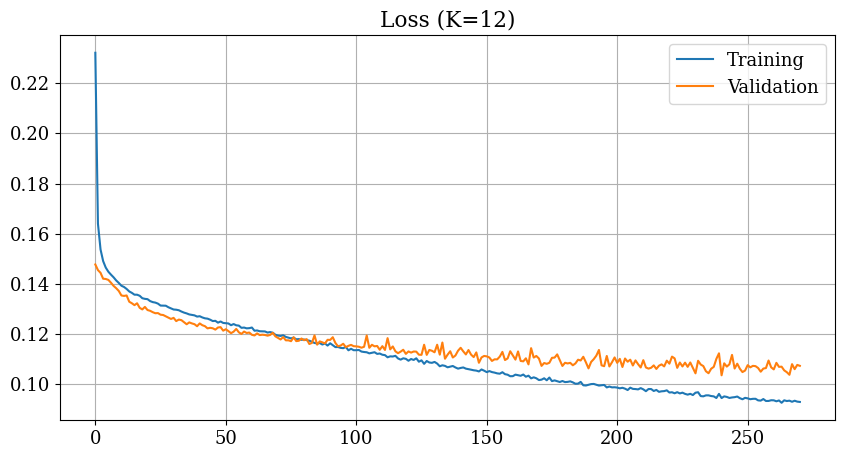

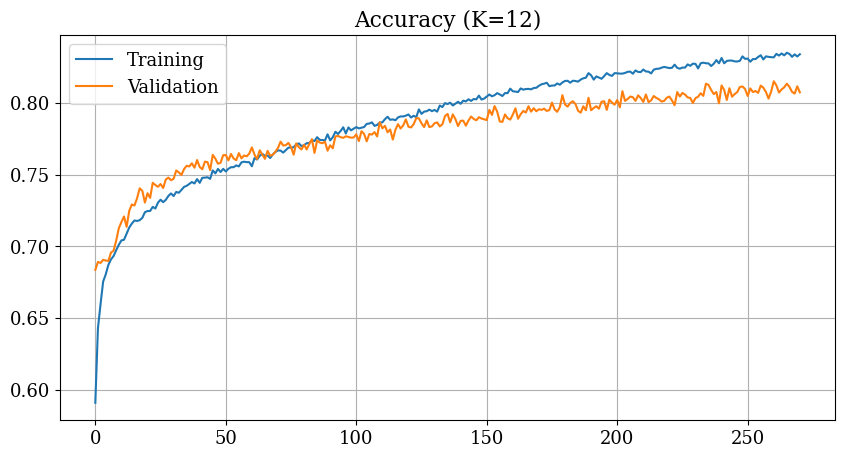

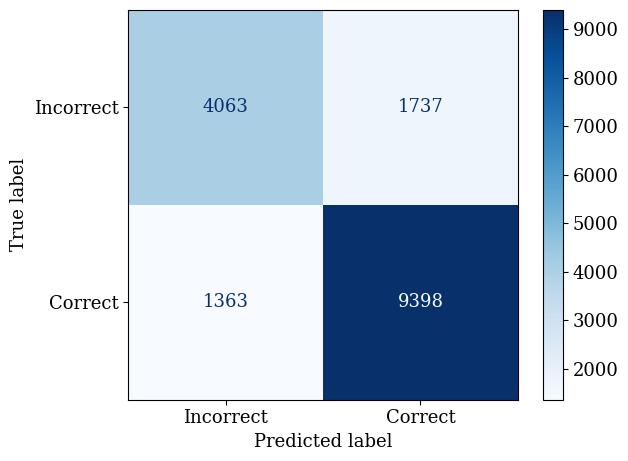

In [35]:
best_model_k12 = load_model(best_path_k12)
evaluate_scores_and_plot(m=best_model_k12, X=X_test_k12, y=y_test, df=df_k12, k=12)

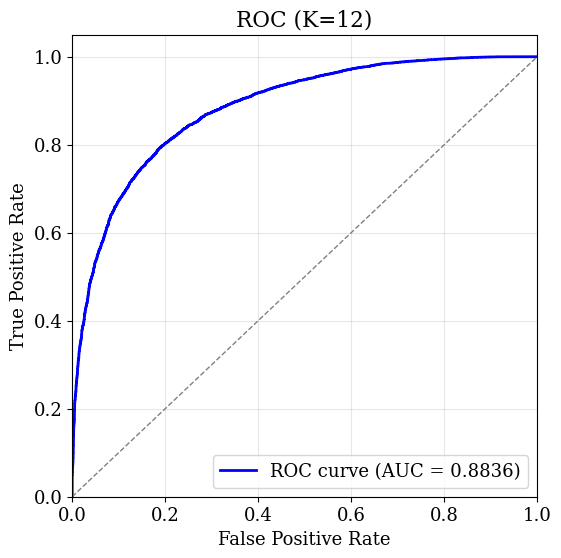

ROC=0.883603153469265



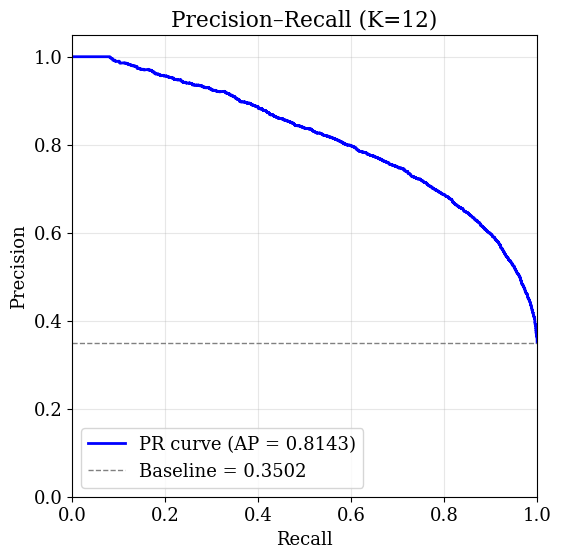

Average precision=0.8143423276330837


In [36]:
roc_k12 = plot_roc_curve(m=best_model_k12, X=X_test_k12, y=y_test, k=12)
print(f'ROC={roc_k12}')
print('')
ap_k12 = plot_pr_curve(m=best_model_k12, X=X_test_k12, y=y_test, k=12)
print(f'Average precision={ap_k12}')

# Feature: 13-mers

In [37]:
build_model(X_train_k13.shape[1], k=13).summary()

Model: "MLP_k13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 256)            │        48,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,393 (357.00 KB)

 Trainable params: 90,497 (353.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [38]:
df_k13, best_path_k13 = train_model(X_train_k13, y_train, X_val_k13, y_val, k=13)

Model saved in: /kaggle/working/model_ecoli_s512_k13_20251003_172248.keras
History saved in: /kaggle/working/history_ecoli_s512_k13_20251003_172248.csv


# Classification Report: (K=13)
Test loss      : 0.10826057195663452
Test accuracy  : 0.7974156141281128
Test precision : 0.8103939890861511
Test recall    : 0.8984295129776001

              precision    recall  f1-score   support

   Incorrect     0.7640    0.6100    0.6784      5800
     Correct     0.8104    0.8984    0.8521     10761

    accuracy                         0.7974     16561
   macro avg     0.7872    0.7542    0.7653     16561
weighted avg     0.7941    0.7974    0.7913     16561




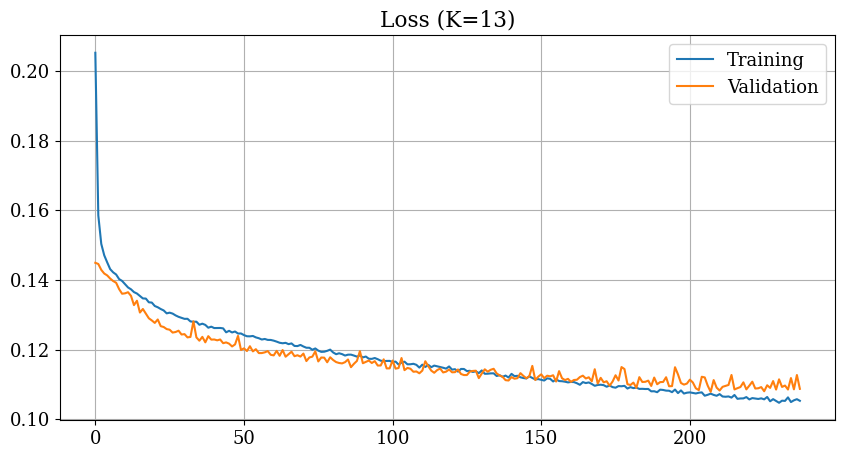

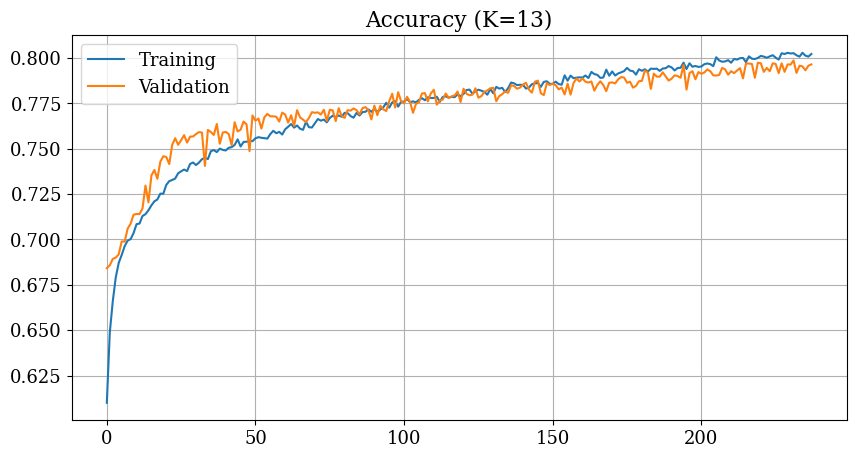

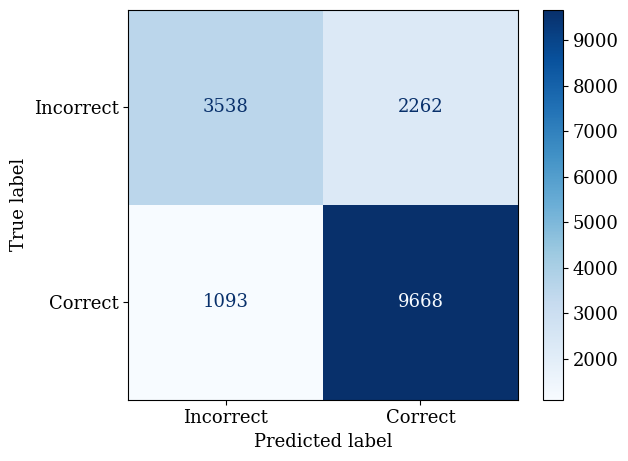

In [39]:
best_model_k13 = load_model(best_path_k13)
evaluate_scores_and_plot(m=best_model_k13, X=X_test_k13, y=y_test, df=df_k13, k=13)

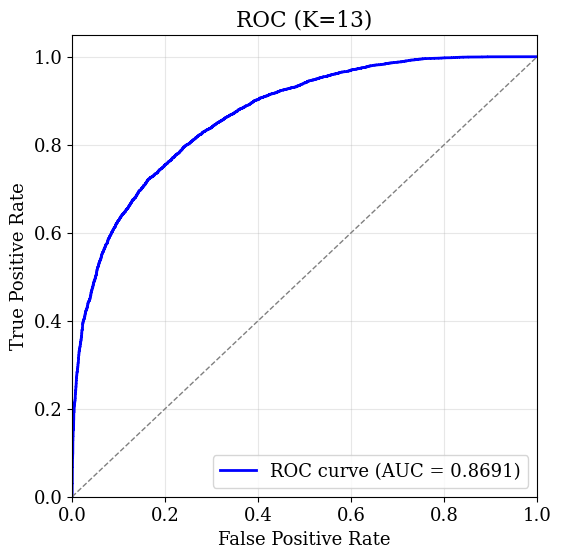

ROC=0.8691446362823607



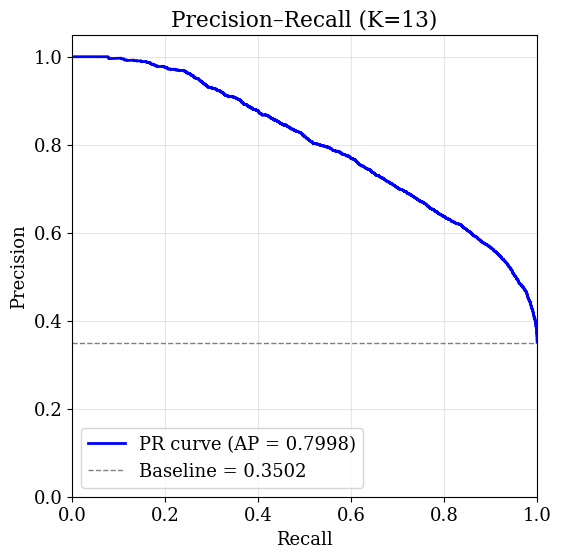

Average precision=0.7997698665667754


In [40]:
roc_k13 = plot_roc_curve(m=best_model_k13, X=X_test_k13, y=y_test, k=13)
print(f'ROC={roc_k13}')
print('')
ap_k13 = plot_pr_curve(m=best_model_k13, X=X_test_k13, y=y_test, k=13)
print(f'Average precision={ap_k13}')

# Feature: 14-mers

In [41]:
build_model(X_train_k14.shape[1], k=14).summary()

Model: "MLP_k14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 256)            │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,137 (356.00 KB)

 Trainable params: 90,241 (352.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
df_k14, best_path_k14 = train_model(X_train_k14, y_train, X_val_k14, y_val, k=14)

Model saved in: /kaggle/working/model_ecoli_s512_k14_20251003_173959.keras
History saved in: /kaggle/working/history_ecoli_s512_k14_20251003_173959.csv


# Classification Report: (K=14)
Test loss      : 0.10746129602193832
Test accuracy  : 0.7945172190666199
Test precision : 0.8131063580513
Test recall    : 0.887835681438446

              precision    recall  f1-score   support

   Incorrect     0.7491    0.6214    0.6793      5800
     Correct     0.8131    0.8878    0.8488     10761

    accuracy                         0.7945     16561
   macro avg     0.7811    0.7546    0.7641     16561
weighted avg     0.7907    0.7945    0.7895     16561




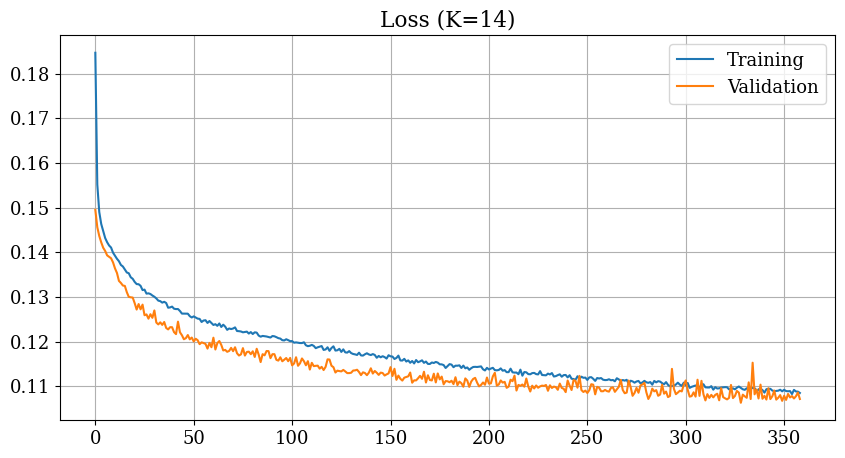

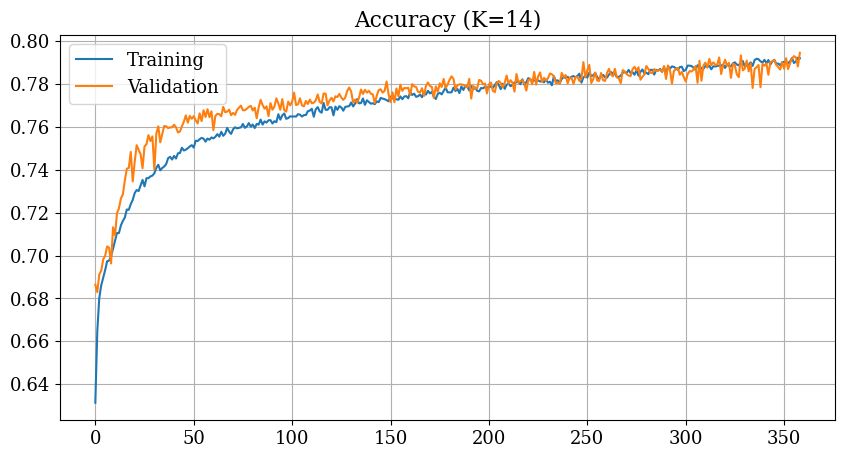

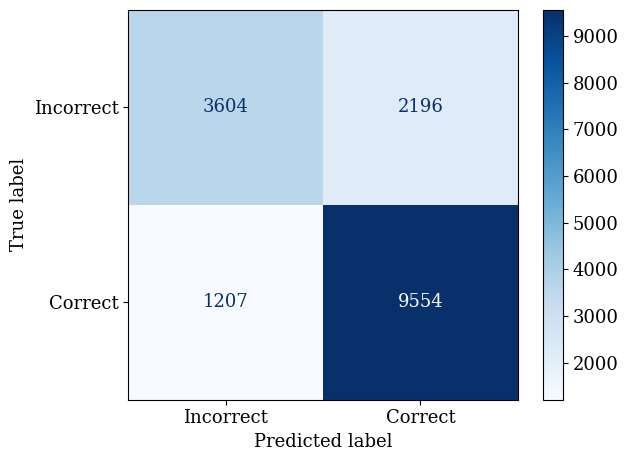

In [43]:
best_model_k14 = load_model(best_path_k14)
evaluate_scores_and_plot(m=best_model_k14, X=X_test_k14, y=y_test, df=df_k14, k=14)

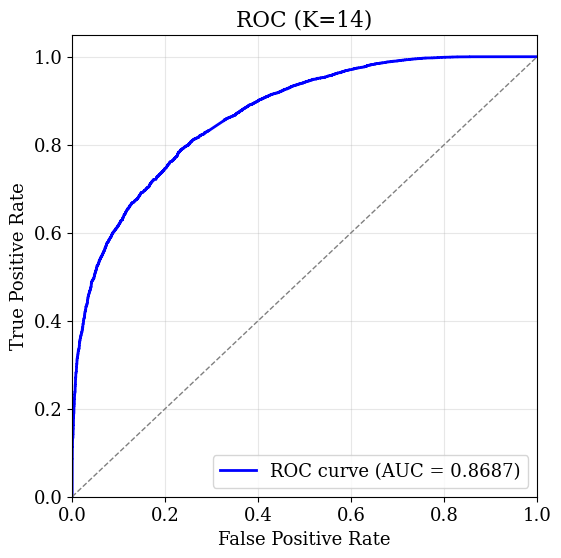

ROC=0.8686827272173782



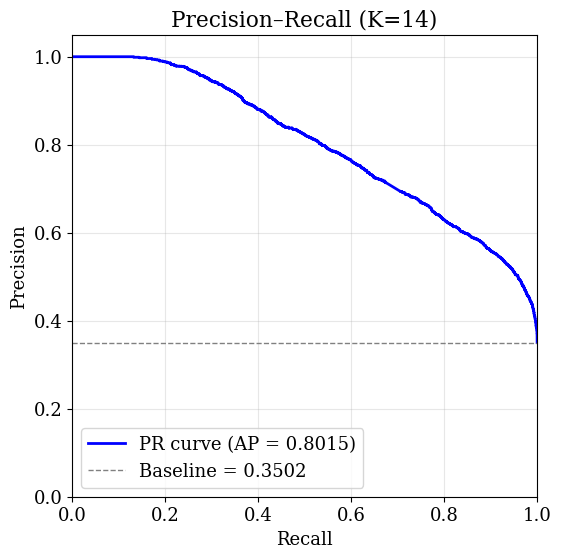

Average precision=0.801547030279179


In [44]:
roc_k14 = plot_roc_curve(m=best_model_k14, X=X_test_k14, y=y_test, k=14)
print(f'ROC={roc_k14}')
print('')
ap_k14 = plot_pr_curve(m=best_model_k14, X=X_test_k14, y=y_test, k=14)
print(f'Average precision={ap_k14}')

# Feature: 15-mers

In [45]:
build_model(X_train_k15.shape[1], k=15).summary()

Model: "MLP_k15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 256)            │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,881 (355.00 KB)

 Trainable params: 89,985 (351.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [46]:
df_k15, best_path_k15 = train_model(X_train_k15, y_train, X_val_k15, y_val, k=15)

Model saved in: /kaggle/working/model_ecoli_s512_k15_20251003_175945.keras
History saved in: /kaggle/working/history_ecoli_s512_k15_20251003_175945.csv


# Classification Report: (K=15)
Test loss      : 0.106840118765831
Test accuracy  : 0.7936719059944153
Test precision : 0.8001962304115295
Test recall    : 0.9095808863639832

              precision    recall  f1-score   support

   Incorrect     0.7752    0.5786    0.6627      5800
     Correct     0.8002    0.9096    0.8514     10761

    accuracy                         0.7937     16561
   macro avg     0.7877    0.7441    0.7570     16561
weighted avg     0.7915    0.7937    0.7853     16561




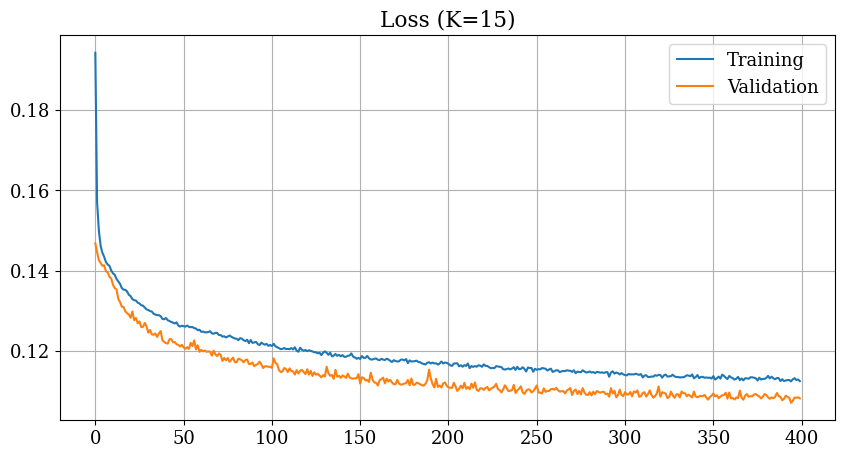

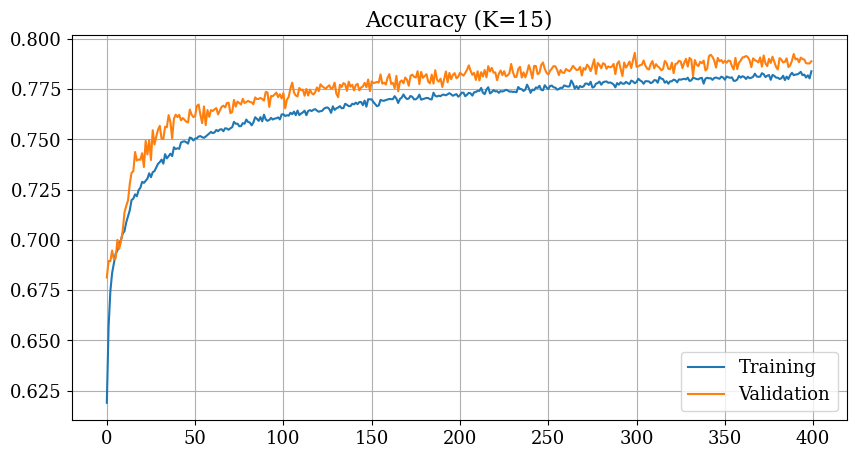

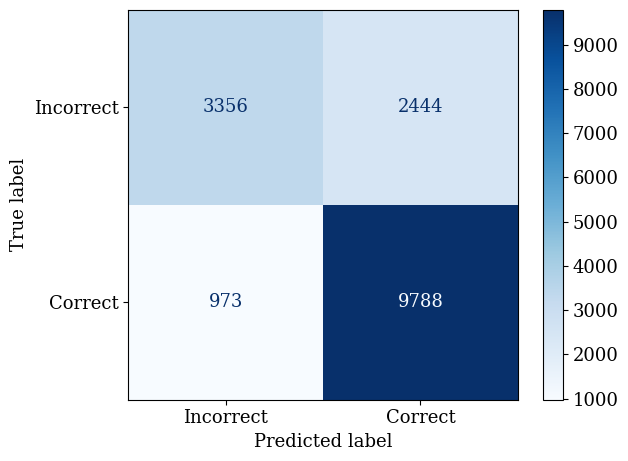

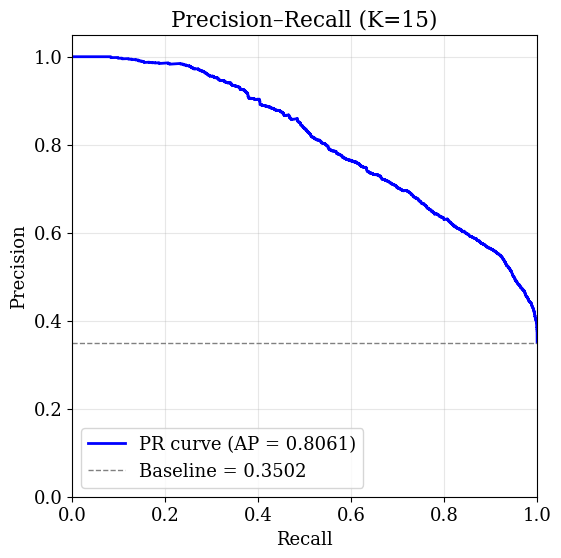

Average precision=0.8061443708702454


In [47]:
best_model_k15 = load_model(best_path_k15)
evaluate_scores_and_plot(m=best_model_k15, X=X_test_k15, y=y_test, df=df_k15, k=15)
print('')
ap_k15 = plot_pr_curve(m=best_model_k15, X=X_test_k15, y=y_test, k=15)
print(f'Average precision={ap_k15}')

# Feature: Without k-mers

In [48]:
build_model(X_train_wo.shape[1], k='none').summary()

Model: "MLP_knone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 47,489 (185.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [49]:
df_wo, best_path_wo = train_model(X_train_wo, y_train, X_val_wo, y_val, k='none')

Model saved in: /kaggle/working/model_ecoli_s512_knone_20251003_181013.keras
History saved in: /kaggle/working/history_ecoli_s512_knone_20251003_181013.csv


# Classification Report: (K=none)
Test loss      : 0.12164195626974106
Test accuracy  : 0.7597367167472839
Test precision : 0.777905285358429
Test recall    : 0.8820741772651672

              precision    recall  f1-score   support

   Incorrect     0.7089    0.5328    0.6083      5800
     Correct     0.7779    0.8821    0.8267     10761

    accuracy                         0.7597     16561
   macro avg     0.7434    0.7074    0.7175     16561
weighted avg     0.7537    0.7597    0.7502     16561




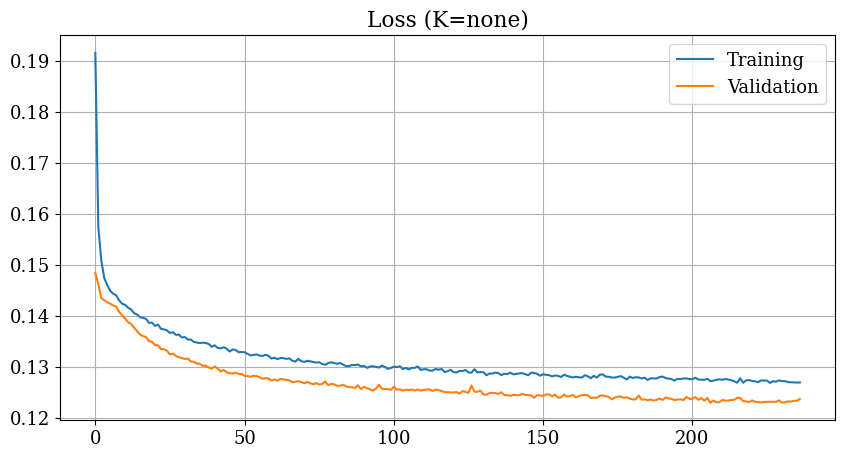

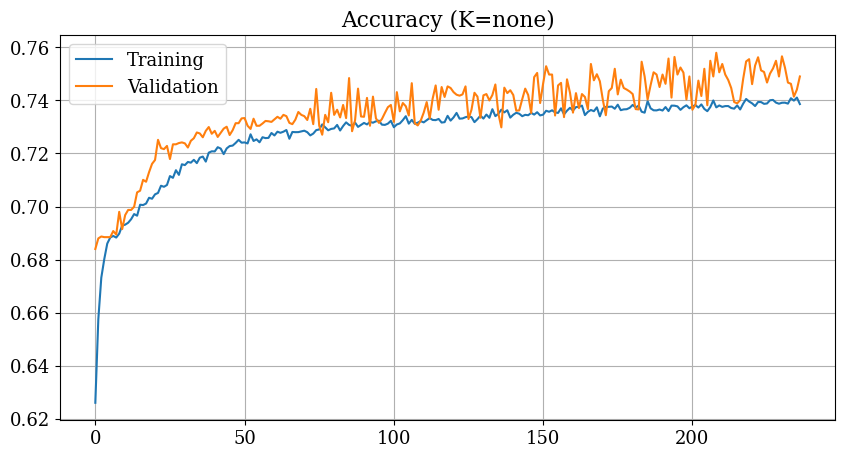

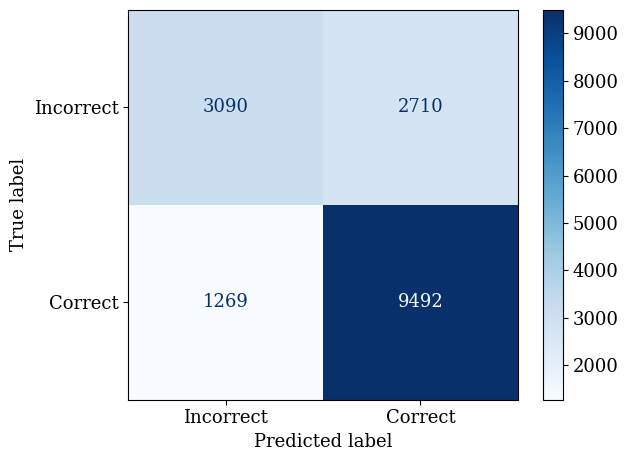

In [50]:
best_model_wo = load_model(best_path_wo)
evaluate_scores_and_plot(m=best_model_wo, X=X_test_wo, y=y_test, df=df_wo, k='none')

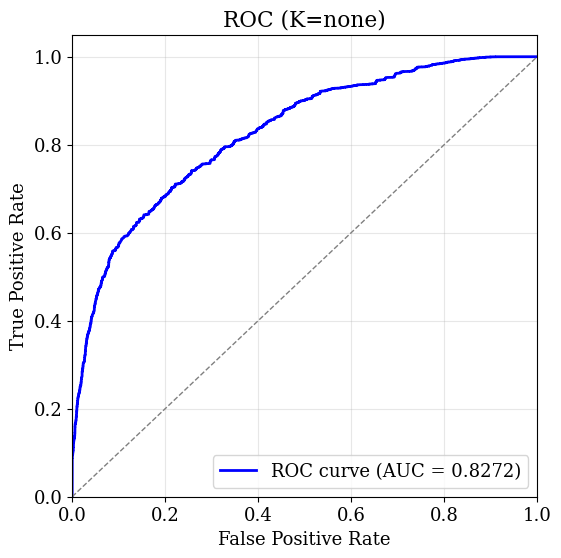

ROC=0.8272307246153895



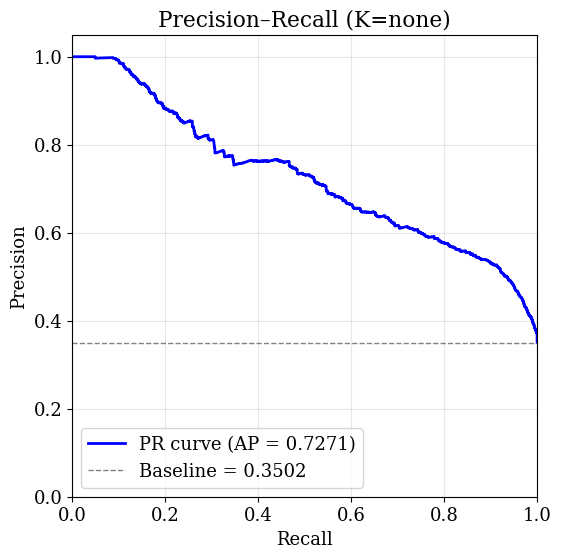

Average precision=0.7270508227865136


In [51]:
roc_wo = plot_roc_curve(m=best_model_wo, X=X_test_wo, y=y_test, k='none')
print(f'ROC={roc_wo}')
print('')
ap_wo = plot_pr_curve(m=best_model_wo, X=X_test_wo, y=y_test, k='none')
print(f'Average precision={ap_wo}')